In [86]:
import tensorflow as tf
from tensorflow.keras.datasets import fashion_mnist
import matplotlib.pyplot as plt
import numpy as np
from skimage.feature import hog
import pandas as pd
from sklearn.feature_selection import VarianceThreshold, SelectPercentile, f_classif
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, ConfusionMatrixDisplay
import numpy as np
from sklearn.metrics import precision_score

import torch
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset


(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

x_train = x_train / 255.0
x_test = x_test / 255.0

x_train = x_train[..., np.newaxis]
x_test = x_test[..., np.newaxis]

print(f"x_train shape: {x_train.shape}, y_train shape: {y_train.shape}")

x_train shape: (60000, 28, 28, 1), y_train shape: (60000,)


In [87]:
x_train_flat = x_train.reshape(x_train.shape[0], -1)
x_test_flat = x_test.reshape(x_test.shape[0], -1)

pca = PCA(n_components=20)
x_train_pca = pca.fit_transform(x_train_flat)
x_test_pca = pca.transform(x_test_flat)

In [88]:
def apply_hog_fixed(images):
    hog_features = []
    for img in images:
        feature, _= hog(img, orientations=9, pixels_per_cell=(8, 8),
                         cells_per_block=(2, 2), visualize=True, channel_axis=2)
        hog_features.append(feature)
    return np.array(hog_features)

hog_features_train = apply_hog_fixed(x_train)
hog_features_test = apply_hog_fixed(x_test)

print(f"HOG Features Train Shape: {hog_features_train.shape}")
print(f"HOG Features Test Shape: {hog_features_test.shape}")

HOG Features Train Shape: (60000, 144)
HOG Features Test Shape: (10000, 144)


## 3.1

In [89]:
scaler = StandardScaler()

scaler.fit(x_train_pca)

x_train_pca_standardized = scaler.transform(x_train_pca)

x_test_pca_standardized = scaler.transform(x_test_pca)


scaler_hog = StandardScaler()
x_train_hog_standardized = scaler_hog.fit_transform(hog_features_train)
x_test_hog_standardized = scaler_hog.transform(hog_features_test)

x_train_combined = np.hstack((x_train_pca_standardized, x_train_hog_standardized))
x_test_combined = np.hstack((x_test_pca_standardized, x_test_hog_standardized))


select_percentile = SelectPercentile(f_classif, percentile=35)
x_train_final = select_percentile.fit_transform(x_train_combined, y_train)
x_test_final = select_percentile.transform(x_test_combined)

print(f"Dimensiuni finale: Train: {x_train_final.shape}, Test: {x_test_final.shape}")



Dimensiuni finale: Train: (60000, 58), Test: (10000, 58)


# Functie de antrenare

In [90]:
def train_model(model, train_loader, test_loader, num_epochs=20, lr=0.00001, optimizer=None, scheduler=None):
    criterion = nn.CrossEntropyLoss()
    if (optimizer == None):
        optimizer = optim.Adam(model.parameters(), lr=lr)
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(device)
    model.to(device)

    train_losses, test_losses, train_accuracies, test_accuracies = [], [], [], []

    for epoch in range(num_epochs):
        # Training
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        train_losses.append(running_loss / len(train_loader))
        train_accuracies.append(correct / total)
        if scheduler:
            scheduler.step()
        # Testing
        model.eval()
        running_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                running_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                correct += (predicted == labels).sum().item()
                total += labels.size(0)

        test_losses.append(running_loss / len(test_loader))
        test_accuracies.append(correct / total)

        print(f"Epoch {epoch+1}/{num_epochs},\n Train Loss: {train_losses[-1]:.4f},\n Test Loss: {test_losses[-1]:.4f}, "
              f"\nTrain Acc: {train_accuracies[-1]:.4f},\n Test Acc: {test_accuracies[-1]:.4f}")

    return train_losses, test_losses, train_accuracies, test_accuracies, device

In [91]:

x_train_tensor = torch.Tensor(x_train_final)
x_test_tensor = torch.Tensor(x_test_final)
y_train_tensor = torch.LongTensor(y_train)
y_test_tensor = torch.LongTensor(y_test)

train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
test_dataset = TensorDataset(x_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)



In [92]:

class MLP(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size):
        super(MLP, self).__init__()
        
        self.fc1 = nn.Linear(input_size, hidden_sizes)
        self.fc2 = nn.Linear(hidden_sizes, hidden_sizes)
        self.fc3 = nn.Linear(hidden_sizes, output_size)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x


input_size = x_train_final.shape[1]
hidden_sizes = 100
output_size = 10



cuda
Epoch 1/20,
 Train Loss: 2.1464,
 Test Loss: 1.9699, 
Train Acc: 0.2140,
 Test Acc: 0.3565
Epoch 2/20,
 Train Loss: 1.7647,
 Test Loss: 1.5707, 
Train Acc: 0.4461,
 Test Acc: 0.5239
Epoch 3/20,
 Train Loss: 1.4145,
 Test Loss: 1.2886, 
Train Acc: 0.5579,
 Test Acc: 0.5991
Epoch 4/20,
 Train Loss: 1.1938,
 Test Loss: 1.1233, 
Train Acc: 0.6107,
 Test Acc: 0.6319
Epoch 5/20,
 Train Loss: 1.0614,
 Test Loss: 1.0176, 
Train Acc: 0.6430,
 Test Acc: 0.6560
Epoch 6/20,
 Train Loss: 0.9719,
 Test Loss: 0.9430, 
Train Acc: 0.6657,
 Test Acc: 0.6662
Epoch 7/20,
 Train Loss: 0.9073,
 Test Loss: 0.8881, 
Train Acc: 0.6798,
 Test Acc: 0.6832
Epoch 8/20,
 Train Loss: 0.8586,
 Test Loss: 0.8467, 
Train Acc: 0.6912,
 Test Acc: 0.6947
Epoch 9/20,
 Train Loss: 0.8211,
 Test Loss: 0.8141, 
Train Acc: 0.6995,
 Test Acc: 0.7024
Epoch 10/20,
 Train Loss: 0.7911,
 Test Loss: 0.7879, 
Train Acc: 0.7076,
 Test Acc: 0.7076
Epoch 11/20,
 Train Loss: 0.7664,
 Test Loss: 0.7658, 
Train Acc: 0.7131,
 Test Acc:

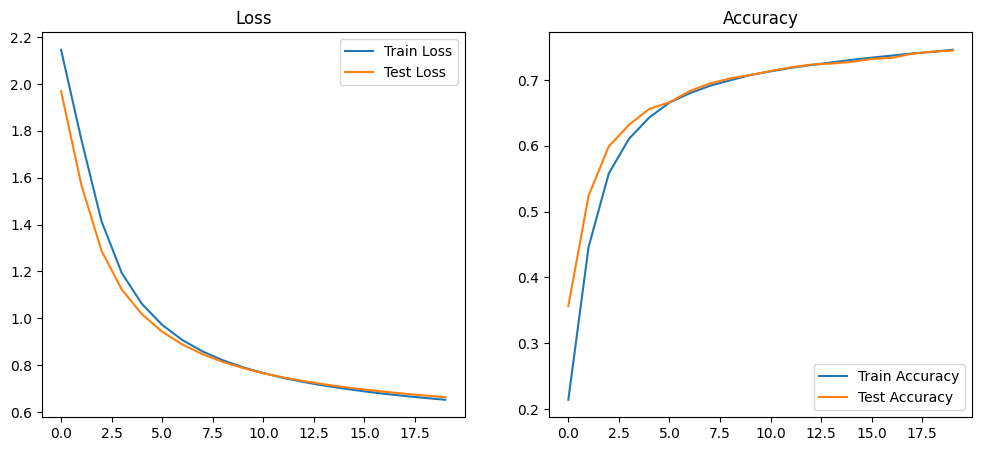

In [93]:
model = MLP(input_size, hidden_sizes, output_size)
train_losses, test_losses, train_accuracies, test_accuracies, device = train_model(model, train_loader, test_loader, num_epochs=20, lr=0.00001)

# Curbele de pierdere
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.title('Loss')
plt.legend()

# Curbele de acuratețe
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.title('Accuracy')
plt.legend()

plt.show()


## 3.2

In [94]:

x_train_tensor = torch.Tensor(x_train.reshape(x_train.shape[0], -1))
x_test_tensor = torch.Tensor(x_test.reshape(x_test.shape[0], -1))
y_train_tensor = torch.LongTensor(y_train)
y_test_tensor = torch.LongTensor(y_test)

train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
test_dataset = TensorDataset(x_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


input_size = x_train.shape[1] * x_train.shape[2]
hidden_sizes = 100



cuda
Epoch 1/30,
 Train Loss: 2.0105,
 Test Loss: 1.6565, 
Train Acc: 0.4098,
 Test Acc: 0.6116
Epoch 2/30,
 Train Loss: 1.3506,
 Test Loss: 1.1372, 
Train Acc: 0.6388,
 Test Acc: 0.6455
Epoch 3/30,
 Train Loss: 1.0143,
 Test Loss: 0.9388, 
Train Acc: 0.6658,
 Test Acc: 0.6665
Epoch 4/30,
 Train Loss: 0.8742,
 Test Loss: 0.8418, 
Train Acc: 0.6862,
 Test Acc: 0.6931
Epoch 5/30,
 Train Loss: 0.7967,
 Test Loss: 0.7821, 
Train Acc: 0.7112,
 Test Acc: 0.7108
Epoch 6/30,
 Train Loss: 0.7452,
 Test Loss: 0.7399, 
Train Acc: 0.7320,
 Test Acc: 0.7307
Epoch 7/30,
 Train Loss: 0.7071,
 Test Loss: 0.7068, 
Train Acc: 0.7489,
 Test Acc: 0.7496
Epoch 8/30,
 Train Loss: 0.6765,
 Test Loss: 0.6795, 
Train Acc: 0.7621,
 Test Acc: 0.7590
Epoch 9/30,
 Train Loss: 0.6504,
 Test Loss: 0.6560, 
Train Acc: 0.7734,
 Test Acc: 0.7696
Epoch 10/30,
 Train Loss: 0.6278,
 Test Loss: 0.6365, 
Train Acc: 0.7830,
 Test Acc: 0.7784
Epoch 11/30,
 Train Loss: 0.6085,
 Test Loss: 0.6193, 
Train Acc: 0.7919,
 Test Acc:

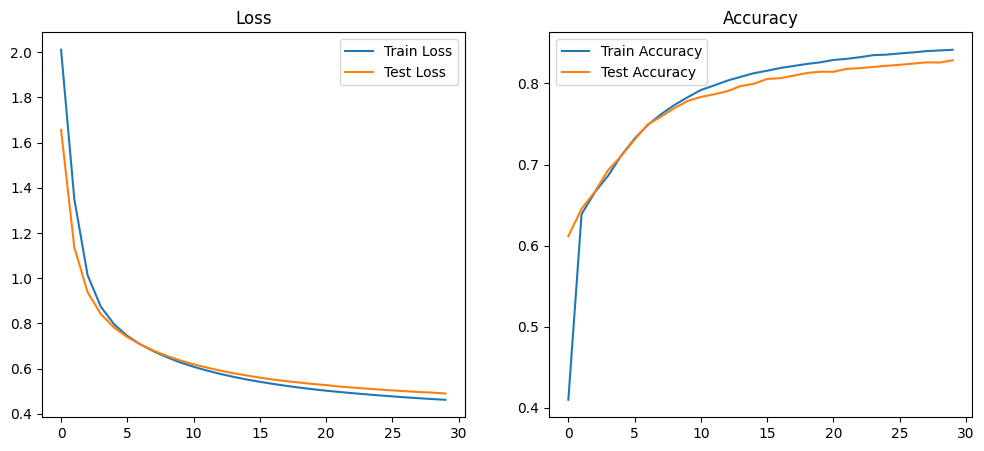

In [95]:

output_size = 10

model = MLP(input_size, hidden_sizes, output_size)
train_losses, test_losses, train_accuracies, test_accuracies, device = train_model(model, train_loader, test_loader, num_epochs=30, lr=0.00001)


# Curbele de pierdere
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.title('Loss')
plt.legend()

# Curbele de acuratețe
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.title('Accuracy')
plt.legend()

plt.show()


              precision    recall  f1-score   support

           0       0.80      0.80      0.80      1000
           1       0.97      0.95      0.96      1000
           2       0.72      0.71      0.72      1000
           3       0.82      0.85      0.83      1000
           4       0.69      0.76      0.73      1000
           5       0.94      0.89      0.91      1000
           6       0.61      0.53      0.56      1000
           7       0.89      0.91      0.90      1000
           8       0.93      0.94      0.94      1000
           9       0.91      0.94      0.93      1000

    accuracy                           0.83     10000
   macro avg       0.83      0.83      0.83     10000
weighted avg       0.83      0.83      0.83     10000



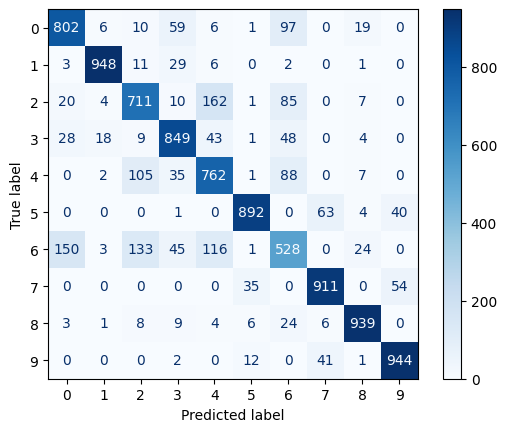

In [96]:
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

# Preziceri pe setul de test
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

print(classification_report(all_labels, all_preds))
ConfusionMatrixDisplay.from_predictions(all_labels, all_preds, cmap='Blues')
plt.show()

## 3.3

In [97]:
def conv3x3(in_planes, out_planes, stride=1, padding=1):
    """
    3x3 2D convolution with padding=1
    @:param in_planes: the number of input channels for the convolution filter
    @:param out_planes: the number of output channels for the convolution filter
    @:param stride: stride value for the convolution filter, default is 1
    @:param padding: the padding to apply, default is 1 to keep width and height the same in the output activation maps 
    """
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=padding, bias=False)


def conv1x1(in_planes, out_planes, stride=1):
    """
    1x1 2D convolution
    @:param in_planes: the number of input channels for the convolution filter
    @:param out_planes: the number of output channels for the convolution filter
    @:param stride: stride value for the convolution filter, default is 1
    """
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)

In [98]:
class ConvBlock(nn.Module):
    def __init__(self, bottleneck_channels, block_channels, norm_layer=nn.BatchNorm2d):
        super(ConvBlock, self).__init__()

        # first conv 1x1 layer which implements the bottlenecking
        self.conv1 = conv1x1(block_channels, bottleneck_channels)
        self.norm1 = norm_layer(bottleneck_channels)

        # conv 3x3 layer which applies the stride given as parameter
        self.conv2 = conv3x3(bottleneck_channels, bottleneck_channels)
        self.norm2 = norm_layer(bottleneck_channels)

        # conv 1x1 layer where the number of output channels is "expanded" according to the defined expansion factor
        # according to the above figure, the expansion factor is set to 4
        self.conv3 = conv1x1(bottleneck_channels, block_channels)
        self.norm3 = norm_layer(block_channels)

        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        identity = x

        # first layer conv1 + bn1 + relu
        out = self.conv1(x)
        out = self.norm1(out)
        out = self.relu(out)

        # second layer conv2 + bn2 + relu
        out = self.conv2(out)
        out = self.norm2(out)
        out = self.relu(out)

        # third layer conv3 + bn3
        out = self.conv3(out)
        out = self.norm3(out)

        # add identity to residual and apply relu
        out += identity
        out = self.relu(out)

        return out



In [99]:
class DeepConvNet(nn.Module):
    def __init__(self, norm_layer=nn.BatchNorm2d, base_depth=16, expansion=4, nr_layer_blocks=1, num_classes=10):
        super(DeepConvNet, self).__init__()

        self.norm_layer = norm_layer
        self.base_depth = base_depth
        self.conv1 = nn.Conv2d(nr_layer_blocks, self.base_depth, kernel_size=7, stride=2, padding=3,
                               bias=False)  # image is now 16x16
        self.norm1 = norm_layer(self.base_depth)
        self.relu = nn.ReLU(inplace=True)

        # change to 64 channels base and image size 16x16
        depth1 = self.base_depth * expansion
        self.conv_depth1 = conv1x1(self.base_depth, depth1, stride=1)
        self.norm_depth1 = norm_layer(depth1)

        # #### Layer 1, 3 blocks
        self.layer1 = nn.Sequential(
            *[ConvBlock(self.base_depth, depth1, norm_layer=self.norm_layer)] * nr_layer_blocks
        )

        # change to 128 channels base and image size 8x8
        depth2 = depth1 * 2
        # TODO 3.1 - Definiti convolutia 2D cu kernel de dimensiune 1x1 care injumatateste imaginea
        self.conv_depth2 = conv1x1(depth1, depth2)
        self.norm_depth2 = norm_layer(depth2)

        # #### Layer 2, 3 blocks
        # TODO 3.2 - Definiti secventa de ConvBlocks pentru Layer 2
        self.layer2 = nn.Sequential(
            *[ConvBlock(depth1, depth2, norm_layer=self.norm_layer)] * nr_layer_blocks
        )

        # change to 256 chanels and image size 4x4
        depth3 = depth2 * 2
        # TODO 3.3 - Definiti convolutia 2D cu kernel de dimensiune 1x1 care injumatateste imaginea
        self.conv_depth3 = conv1x1(depth2, depth3)
        self.norm_depth3 = norm_layer(depth3)

        # Layer 3, 3 blocks
        # TODO 3.4 - Definiti secventa de ConvBlocks pentru Layer 3
        self.layer3 = nn.Sequential(
            *[ConvBlock(depth2, depth3, norm_layer=self.norm_layer)] * nr_layer_blocks
        )

        # AveragePooling
        # TODO 3.5 - Definiti straturile de GlobalAveragePooling si stratul Fully Connected
        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(256, 10)
        self.dropout = nn.Dropout(0.5)


    def forward(self, x):
        # initial conv
        x = self.conv1(x)
        x = self.norm1(x)
        x = self.relu(x)

        # TODO 3.6 apply depth1 transform + layer 1
        x = self.layer1(self.norm_depth1(self.conv_depth1(x)))
        #am adaugat dropout
        x = self.dropout(x)
        # TODO 3.7 apply depth2 transform + layer 2
        x = self.layer2(self.norm_depth2(self.conv_depth2(x)))

        # TODO 3.8 apply depth3 transform + layer 3
        x = self.layer3(self.norm_depth3(self.conv_depth3(x)))

        # apply global average pooling + linearize + FC
        x = self.avgpool(x)
        x=x.view(-1, 256)
        x=self.fc(x)

        return x

In [100]:

x_train_tensor = torch.Tensor(x_train).permute(0, 3, 1, 2)
x_test_tensor = torch.Tensor(x_test).permute(0, 3, 1, 2)
y_train_tensor = torch.LongTensor(y_train)
y_test_tensor = torch.LongTensor(y_test)

train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
test_dataset = TensorDataset(x_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


input_size = x_train.shape[1] * x_train.shape[2]  # Dimensiunea imaginilor liniarizate

cuda
Epoch 1/30,
 Train Loss: 1.7134,
 Test Loss: 1.2176, 
Train Acc: 0.4392,
 Test Acc: 0.5885
Epoch 2/30,
 Train Loss: 1.1097,
 Test Loss: 0.9195, 
Train Acc: 0.6830,
 Test Acc: 0.6829
Epoch 3/30,
 Train Loss: 0.8998,
 Test Loss: 0.8323, 
Train Acc: 0.7186,
 Test Acc: 0.7016
Epoch 4/30,
 Train Loss: 0.8016,
 Test Loss: 0.7781, 
Train Acc: 0.7347,
 Test Acc: 0.7143
Epoch 5/30,
 Train Loss: 0.7388,
 Test Loss: 0.7352, 
Train Acc: 0.7481,
 Test Acc: 0.7251
Epoch 6/30,
 Train Loss: 0.6963,
 Test Loss: 0.7140, 
Train Acc: 0.7578,
 Test Acc: 0.7315
Epoch 7/30,
 Train Loss: 0.6611,
 Test Loss: 0.6883, 
Train Acc: 0.7675,
 Test Acc: 0.7364
Epoch 8/30,
 Train Loss: 0.6302,
 Test Loss: 0.6736, 
Train Acc: 0.7755,
 Test Acc: 0.7434
Epoch 9/30,
 Train Loss: 0.6119,
 Test Loss: 0.6402, 
Train Acc: 0.7816,
 Test Acc: 0.7553
Epoch 10/30,
 Train Loss: 0.5886,
 Test Loss: 0.6402, 
Train Acc: 0.7871,
 Test Acc: 0.7526
Epoch 11/30,
 Train Loss: 0.5751,
 Test Loss: 0.6148, 
Train Acc: 0.7933,
 Test Acc:

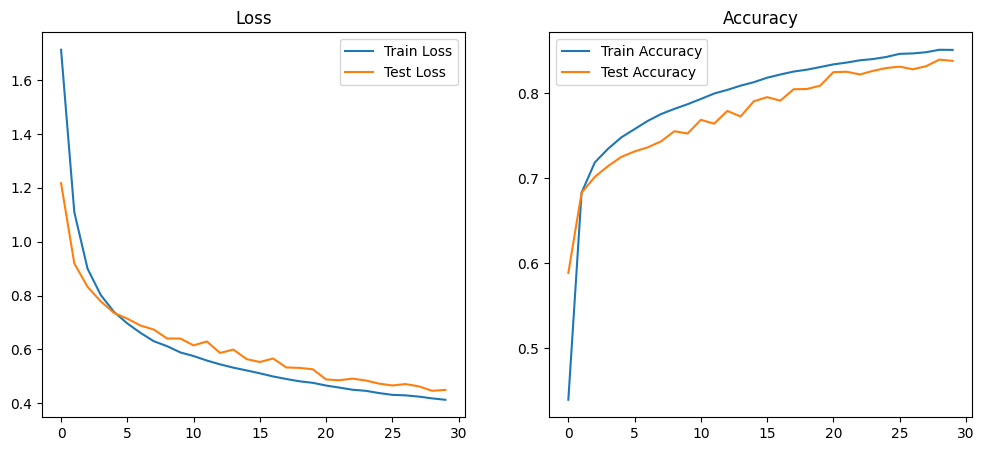

In [101]:
model = DeepConvNet(num_classes=10)
train_losses2, test_losses2, train_accuracies2, test_accuracies2, device = train_model(model, train_loader, test_loader, num_epochs=30, lr=0.00001)


plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses2, label='Train Loss')
plt.plot(test_losses2, label='Test Loss')
plt.title('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies2, label='Train Accuracy')
plt.plot(test_accuracies2, label='Test Accuracy')
plt.title('Accuracy')
plt.legend()

plt.show()

              precision    recall  f1-score   support

           0       0.75      0.88      0.81      1000
           1       0.92      0.97      0.95      1000
           2       0.76      0.81      0.79      1000
           3       0.91      0.80      0.85      1000
           4       0.76      0.74      0.75      1000
           5       0.99      0.78      0.88      1000
           6       0.62      0.54      0.58      1000
           7       0.78      0.98      0.87      1000
           8       0.97      0.95      0.96      1000
           9       0.95      0.92      0.93      1000

    accuracy                           0.84     10000
   macro avg       0.84      0.84      0.84     10000
weighted avg       0.84      0.84      0.84     10000



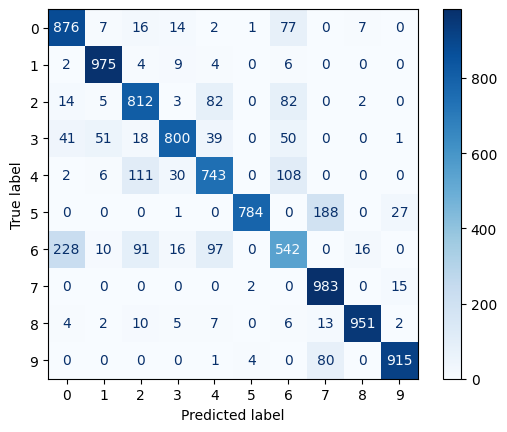

In [102]:
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

# Preziceri pe setul de test
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

print(classification_report(all_labels, all_preds))
ConfusionMatrixDisplay.from_predictions(all_labels, all_preds, cmap='Blues')
plt.show()

In [103]:
import torchvision
import torchvision.transforms as transforms

DATA_MEAN = (0.5,)	
DATA_STD = (0.5,)	

train_transform = transforms.Compose(
    [
        transforms.RandomHorizontalFlip(),     # apply random horizontal flip
        transforms.RandomCrop(                          # apply random crop, after padding image with 4 values on each side, using reflect mode
            size=(28, 28), 
            padding=(4, 4), 
            padding_mode="reflect"),
        transforms.ToTensor(),
        transforms.Normalize(DATA_MEAN, DATA_STD)       # normalize the image tensor to [-1, 1] on each channel: img_norm = (img - data_mean) / data_std 
    ] 
)


test_transform = transforms.Compose(
    [
        transforms.ToTensor(),                          # on test set we only need to apply the same normalization
        transforms.Normalize(DATA_MEAN, DATA_STD) 
    ] 
)



input_size = x_train.shape[1] * x_train.shape[2]  # Dimensiunea imaginilor liniarizate


trainset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=train_transform)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

testset = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=test_transform)
test_loader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)




cuda
Epoch 1/30,
 Train Loss: 1.0334,
 Test Loss: 0.7105, 
Train Acc: 0.6406,
 Test Acc: 0.7266
Epoch 2/30,
 Train Loss: 0.6799,
 Test Loss: 0.6236, 
Train Acc: 0.7534,
 Test Acc: 0.7624
Epoch 3/30,
 Train Loss: 0.6009,
 Test Loss: 0.5360, 
Train Acc: 0.7807,
 Test Acc: 0.8007
Epoch 4/30,
 Train Loss: 0.5497,
 Test Loss: 0.5044, 
Train Acc: 0.8007,
 Test Acc: 0.8169
Epoch 5/30,
 Train Loss: 0.5224,
 Test Loss: 0.4654, 
Train Acc: 0.8089,
 Test Acc: 0.8355
Epoch 6/30,
 Train Loss: 0.4944,
 Test Loss: 0.4368, 
Train Acc: 0.8181,
 Test Acc: 0.8438
Epoch 7/30,
 Train Loss: 0.4758,
 Test Loss: 0.4124, 
Train Acc: 0.8262,
 Test Acc: 0.8513
Epoch 8/30,
 Train Loss: 0.4626,
 Test Loss: 0.4059, 
Train Acc: 0.8308,
 Test Acc: 0.8555
Epoch 9/30,
 Train Loss: 0.4467,
 Test Loss: 0.4418, 
Train Acc: 0.8353,
 Test Acc: 0.8409
Epoch 10/30,
 Train Loss: 0.4352,
 Test Loss: 0.4038, 
Train Acc: 0.8406,
 Test Acc: 0.8558
Epoch 11/30,
 Train Loss: 0.4262,
 Test Loss: 0.3835, 
Train Acc: 0.8434,
 Test Acc:

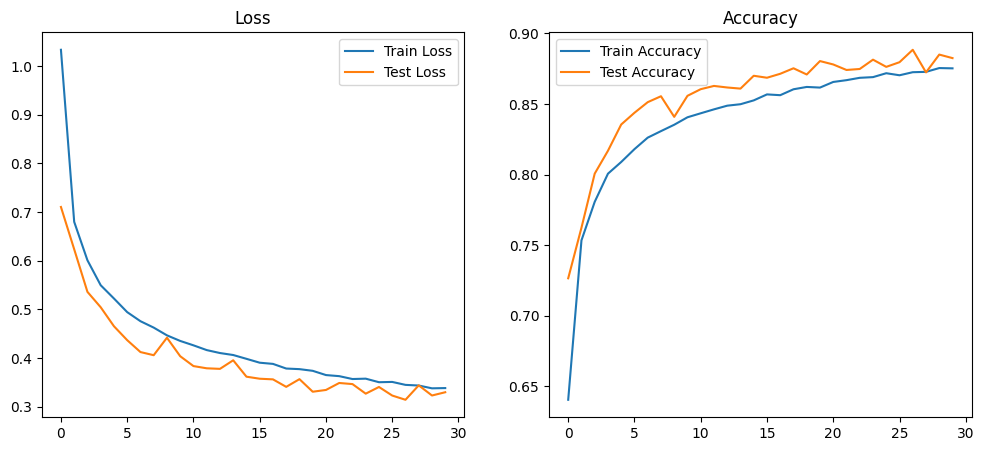

In [104]:
model = DeepConvNet(num_classes=10)
train_losses, test_losses, train_accuracies, test_accuracies, device = train_model(model, train_loader, test_loader, num_epochs=30, lr=0.0001)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.title('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.title('Accuracy')
plt.legend()

plt.show()



              precision    recall  f1-score   support

           0       0.77      0.90      0.83      1000
           1       0.99      0.98      0.98      1000
           2       0.79      0.89      0.84      1000
           3       0.93      0.81      0.87      1000
           4       0.78      0.80      0.79      1000
           5       0.98      0.95      0.97      1000
           6       0.74      0.61      0.67      1000
           7       0.90      0.98      0.94      1000
           8       0.97      0.98      0.97      1000
           9       0.98      0.93      0.96      1000

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000



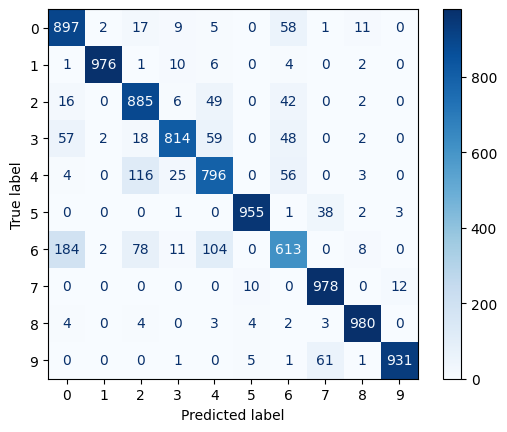

In [106]:
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

# Preziceri pe setul de test
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

print(classification_report(all_labels, all_preds))
ConfusionMatrixDisplay.from_predictions(all_labels, all_preds, cmap='Blues')
plt.show()

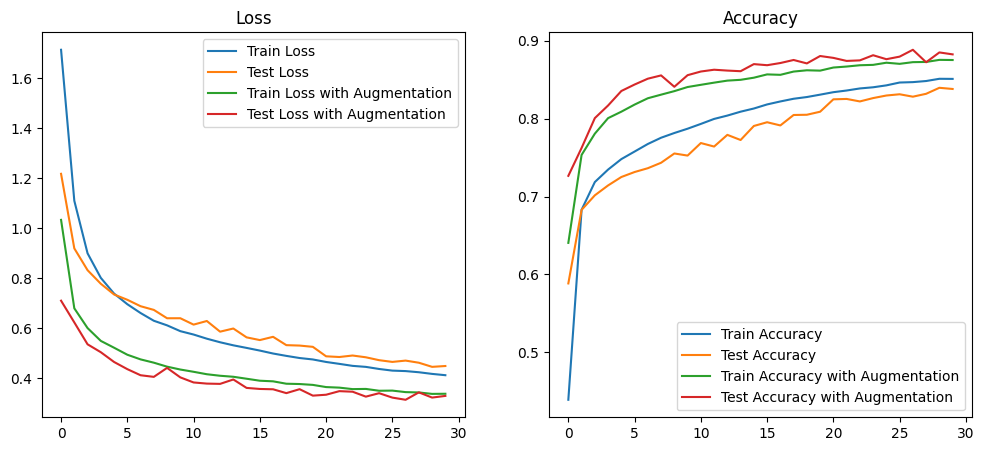

In [107]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses2, label='Train Loss')
plt.plot(test_losses2, label='Test Loss')
plt.plot(train_losses, label='Train Loss with Augmentation')
plt.plot(test_losses, label='Test Loss with Augmentation')
plt.title('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies2, label='Train Accuracy')
plt.plot(test_accuracies2, label='Test Accuracy')
plt.plot(train_accuracies, label='Train Accuracy with Augmentation')
plt.plot(test_accuracies, label='Test Accuracy with Augmentation')
plt.title('Accuracy')
plt.legend()

plt.show()


## 3.4

cuda
Epoch 1/30,
 Train Loss: 0.7843,
 Test Loss: 0.3138, 
Train Acc: 0.8399,
 Test Acc: 0.8933
Epoch 2/30,
 Train Loss: 0.2435,
 Test Loss: 0.2186, 
Train Acc: 0.9184,
 Test Acc: 0.9249
Epoch 3/30,
 Train Loss: 0.1952,
 Test Loss: 0.2297, 
Train Acc: 0.9324,
 Test Acc: 0.9192
Epoch 4/30,
 Train Loss: 0.1620,
 Test Loss: 0.2192, 
Train Acc: 0.9439,
 Test Acc: 0.9260
Epoch 5/30,
 Train Loss: 0.1360,
 Test Loss: 0.2122, 
Train Acc: 0.9521,
 Test Acc: 0.9282
Epoch 6/30,
 Train Loss: 0.1197,
 Test Loss: 0.2158, 
Train Acc: 0.9585,
 Test Acc: 0.9264
Epoch 7/30,
 Train Loss: 0.1012,
 Test Loss: 0.2074, 
Train Acc: 0.9654,
 Test Acc: 0.9322
Epoch 8/30,
 Train Loss: 0.0896,
 Test Loss: 0.2220, 
Train Acc: 0.9691,
 Test Acc: 0.9277
Epoch 9/30,
 Train Loss: 0.0777,
 Test Loss: 0.2214, 
Train Acc: 0.9727,
 Test Acc: 0.9329
Epoch 10/30,
 Train Loss: 0.0654,
 Test Loss: 0.2409, 
Train Acc: 0.9771,
 Test Acc: 0.9292
Epoch 11/30,
 Train Loss: 0.0260,
 Test Loss: 0.2219, 
Train Acc: 0.9927,
 Test Acc:

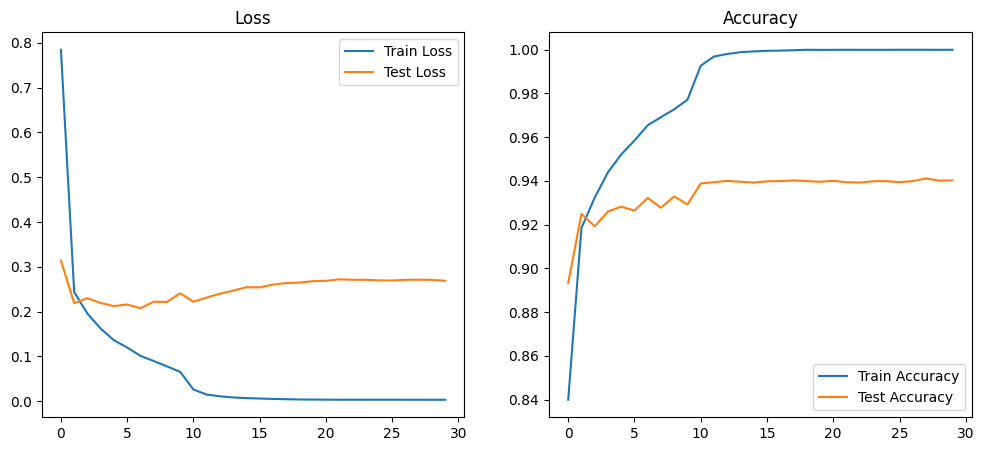

In [ ]:
from cifar10_models.resnet import resnet18

model = resnet18(pretrained=True)

num_classes = len(labels)
model.fc = nn.Linear(model.fc.in_features, num_classes)

optimizer = optim.SGD(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
DATA_MEAN = (0.5, 0.5, 0.5)
DATA_STD = (0.5, 0.5, 0.5)

transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize(DATA_MEAN, DATA_STD)
])

train_dataset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

train_losses, test_losses, train_accuracies, test_accuracies, device = train_model(model, train_loader, test_loader, num_epochs=30, lr=0.0001, optimizer=optimizer, scheduler=scheduler)


plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.title('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.title('Accuracy')
plt.legend()

plt.show()


              precision    recall  f1-score   support

           0       0.90      0.89      0.89      1000
           1       1.00      0.99      0.99      1000
           2       0.90      0.92      0.91      1000
           3       0.94      0.95      0.95      1000
           4       0.91      0.92      0.91      1000
           5       0.99      0.99      0.99      1000
           6       0.84      0.80      0.82      1000
           7       0.97      0.98      0.97      1000
           8       0.99      0.99      0.99      1000
           9       0.97      0.97      0.97      1000

    accuracy                           0.94     10000
   macro avg       0.94      0.94      0.94     10000
weighted avg       0.94      0.94      0.94     10000



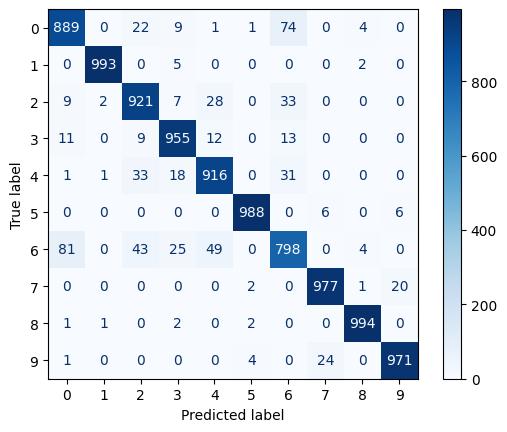

In [77]:
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

# Preziceri pe setul de test
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

print(classification_report(all_labels, all_preds))
ConfusionMatrixDisplay.from_predictions(all_labels, all_preds, cmap='Blues')
plt.show()